In [1]:
#load packages
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [2]:
#function for cleaning the data
def data_prep(data):
    data.columns = ['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
                    'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
                    'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
                    'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']
    data = data.drop('id', axis=1)
    data = data.drop('C1', axis = 1)
    data = data.drop('C14', axis = 1)
    str(data['hour'][4])[-2:]
    hours = [str(i)[-2:] for i in data['hour']]
    data['hours_clean'] = hours
    data = data.drop('hour', axis = 1)
    for i in range(1,data.shape[1]):
        le = LabelEncoder()
        le.fit(data.iloc[:, i].unique())
        data.iloc[:, i] = le.transform(data.iloc[:, i])
    return(data.drop('click', axis = 1), data['click'])

In [3]:
#read the data and process them
data1 = pd.read_csv('trainshuf.csv', nrows = 4.5 * 10 ** 6)
x, y = data_prep(data1)
del data1

In [4]:
#one hot encoding, check the outputs
enc = OneHotEncoder(categorical_features='all', dtype='int64',
       handle_unknown='error', n_values='auto', sparse=True)
x = enc.fit_transform(x)
print(x.shape)
print(y.shape)
print(type(x))
print(type(y))

(4500000, 2339997)
(4500000,)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'pandas.core.series.Series'>


In [5]:
#dictionaries for splitting the dataset into chunks
df_train = {}
df_target = {}
for i in range(1,46):
    df_train["train{0}".format(i)] = x[(i-1) * 100000 : i * 100000, :]
    df_target["target{0}".format(i)] = y[(i-1) * 100000 : i * 100000]

In [6]:
%%timeit -r 5
#model itself
logit = SGDClassifier(loss='log', 
                     penalty='l1', 
                     alpha=0.0001, 
                     fit_intercept=False, 
                     max_iter=100,
                     shuffle=False,
                     n_jobs=1,
                     random_state=19, 
                     learning_rate='optimal', 
                     class_weight= None,
                     warm_start = True)
#fit the model
results = np.zeros((45*6,1))
for j in range(6):
    for i in range(1,46):
        g = np.random.randint(low = 1, high = 45)
        logit.partial_fit(df_train["train{0}".format(g)], df_target["target{0}".format(g)],
                          classes = np.unique(y))
        target_predicted = logit.predict_proba(df_train['train45'])
        results[i-1 + j*45] = np.mean(target_predicted[:,1])
    print(j)
    
order = np.reshape(np.arange(1,271,1),(270,1))
plot_df = np.hstack((results, order))

    

0
0
0
0
0
0
11.7 s ± 242 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [6]:
#model itself
logit = SGDClassifier(loss='log', 
                     penalty='l1', 
                     alpha=0.0001, 
                     fit_intercept=False, 
                     max_iter=100,
                     shuffle=True,
                     n_jobs=1,
                     random_state=19, 
                     learning_rate='optimal', 
                     class_weight= None,
                     warm_start = True)
#fit the model
results = np.zeros((45*6,1))
for j in range(6):
    for i in range(1,46):
        g = np.random.randint(low = 1, high = 45)
        logit.partial_fit(df_train["train{0}".format(g)], df_target["target{0}".format(g)],
                          classes = np.unique(y))
        target_predicted = logit.predict_proba(df_train['train45'])
        results[i-1 + j*45] = np.mean(target_predicted[:,1])
    print(j)
    
order = np.reshape(np.arange(1,271,1),(270,1))
plot_df = np.hstack((results, order))

0
1
2
3
4
5


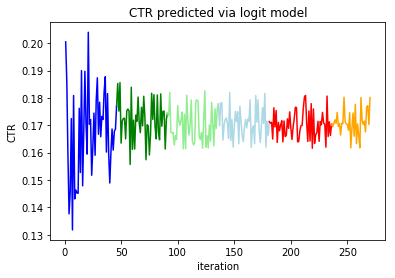

In [8]:
#plot the results
plt.plot(plot_df[:46, 1], plot_df[:46, 0], c = 'blue')
plt.plot(plot_df[45:91, 1], plot_df[45:91, 0], c = 'green')
plt.plot(plot_df[90:136, 1], plot_df[90:136, 0], c = 'lightgreen')
plt.plot(plot_df[135:181, 1], plot_df[135:181, 0], c = 'lightblue')
plt.plot(plot_df[180:236, 1], plot_df[180:236, 0], c = 'red')
plt.plot(plot_df[235:, 1], plot_df[235:, 0], c = 'orange')
plt.title('CTR predicted via logit model')
plt.xlabel('iteration')
plt.ylabel('CTR')
plt.savefig('logitCTR.png', dpi = 1000)
plt.show()